In [1]:
import os
import random
import numpy as np
import tensorflow as tf;
import matplotlib.pyplot as plt
from tqdm import *
from ocr_model import *
from image_utils import *
from random import randint
from training_set_utils import *
from PIL import Image, ImageEnhance, ImageOps

model = OcrModel()
model.load_weights()

Using TensorFlow backend.


loading 1620065590_weights_28x28_c10_acc0.97.h5


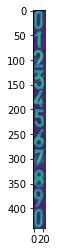

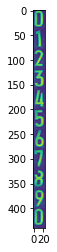

In [6]:
%matplotlib inline
data_set = create_from_atlas_dir("images/atlas/", 24, 40)

In [7]:
%matplotlib inline
data_set = create_variations(data_set)

100%|██████████| 800/800 [03:36<00:00,  3.69it/s]


In [8]:
%matplotlib inline
data_set = data_set + create_from_labeled_dir("images/labeled/")
print(len(data_set))

100%|██████████| 266/266 [00:00<00:00, 6655.84it/s]

2644865


In [9]:
%matplotlib inline

random.shuffle(data_set)

num_test_data = 100
test_set = data_set[:num_test_data]
test_xy = model.convert_data_set(test_set)

train_set = data_set[num_test_data:]
train_xy = model.convert_data_set(train_set)

train_set = None
data_set = None

100%|██████████| 2644765/2644765 [05:17<00:00, 8335.87it/s]


In [10]:
from keras.preprocessing.image import ImageDataGenerator
import time

use_generator = False
batch_size = 32 * 1024

gen = ImageDataGenerator(
        width_shift_range=0, 
        height_shift_range=0, 
        zoom_range=0.1, 
        horizontal_flip=False)
        #rotation_range=10,
        #brightness_range=[0.5, 1.0])

for i in range(1):    
    if use_generator:        
        model.cnn.fit_generator(gen.flow(
            train_xy[0], train_xy[1],
            batch_size=batch_size, shuffle=True), epochs=1, workers=24, steps_per_epoch=len(x_train) / batch_size)
    else:
        model.cnn.fit(
            train_xy[0], train_xy[1],
            epochs=50,
            batch_size=batch_size)
        
    loss_acc = model.cnn.evaluate(test_xy[0], test_xy[1],batch_size=batch_size)    
    model.save_weights("acc" + str(loss_acc[1]))

Train on 2644765 samples
Epoch 1/50
2644765/2644765 [==============================] - 28s 11us/sample - loss: 0.5583 - acc: 0.9282
Epoch 2/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5563 - acc: 0.9293
Epoch 3/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5556 - acc: 0.9296
Epoch 4/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5560 - acc: 0.9293
Epoch 5/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5556 - acc: 0.9296
Epoch 6/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5555 - acc: 0.9293
Epoch 7/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5556 - acc: 0.9293
Epoch 8/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5555 - acc: 0.9292
Epoch 9/50
2644765/2644765 [==============================] - 22s 8us/sample - loss: 0.5557 - acc: 0.9293
Epoch 10/50
2644765/

In [7]:
def argmax2(arr):
    idx0 = 0
    last_max = 0.0
    for i in range(len(arr)):
        if arr[i] > last_max:
            last_max = arr[i]
            idx0 = i    
    idx1 = 0
    last_max = 0.0
    for i in range(len(arr)):
        if i != idx0 and arr[i] > last_max:
            last_max = arr[i]
            idx1 = i
    return (idx0, idx1)

def confidence(arr, pred):
    conv0 = arr[pred[0]]
    conv1 = arr[pred[1]]
    return (round(conv0, 2), round(conv1, 2))

def predict(img):
    result = model.predict(img)
    pred = argmax2(result)
    return (pred, confidence(result, pred))

def predict_test(idx):
    result = predict(test_set[idx].image)
    pred = result[0]
    conf = result[1]
    expect = argmax2(test_set[idx].y)
    expect_conf = confidence(test_set[idx].y, expect)
    if expect_conf[0] > 0.6:
        correct = expect[0] == pred[0]
        print("correct: " + str(correct) + 
              "; expected: " + str(expect) + " " + str(expect_conf) +
              "; predicted: " + str(pred) + " " + str(conf))
        if not correct: # or convidence < 0.9:
            test_set[idx].show()
            #plt.imshow(x_test[idx])
            #plt.show()
    else:
        print("skip")
for i in range(len(test_set)):
    predict_test(i)

correct: True; expected: (9, 8) (0.82, 0.18); predicted: (9, 8) (0.85, 0.15)
correct: True; expected: (4, 5) (0.62, 0.38); predicted: (4, 5) (0.58, 0.42)
skip
skip
correct: True; expected: (0, 1) (0.88, 0.12); predicted: (0, 1) (0.82, 0.18)
correct: True; expected: (3, 2) (0.68, 0.32); predicted: (3, 2) (0.64, 0.36)
correct: True; expected: (4, 3) (0.65, 0.35); predicted: (4, 3) (0.62, 0.38)
correct: True; expected: (8, 9) (0.93, 0.07); predicted: (8, 9) (0.93, 0.07)
correct: True; expected: (2, 3) (0.67, 0.33); predicted: (2, 3) (0.69, 0.31)
correct: True; expected: (9, 0) (1.0, 0.0); predicted: (9, 0) (0.99, 0.01)
correct: True; expected: (4, 3) (0.77, 0.23); predicted: (4, 3) (0.76, 0.24)
correct: True; expected: (6, 7) (0.92, 0.08); predicted: (6, 7) (0.92, 0.08)
correct: True; expected: (7, 8) (0.85, 0.15); predicted: (7, 8) (0.8, 0.2)
skip
correct: True; expected: (9, 0) (0.97, 0.03); predicted: (9, 0) (0.99, 0.01)
correct: True; expected: (5, 6) (0.88, 0.12); predicted: (5, 6) (

In [ ]:
model.export_as_tflite()